In [192]:
# Api docs at: https://github.com/pushshift/api

# Submission search by subreddit

# Subreddits selected: dogs, cats

import requests
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import FreqDist


import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve

stop_words = stopwords.words('english') + [] # Add additional stopwords here

In [194]:
def get_document_features(text):
    word_freq = FreqDist(post_tokenizer(" ".join(text)))
    doc_features = [word for word,freq in word_freq.most_common(500)]
    return doc_features

def post_tokenizer(post):
    post = word_tokenize(post)
    post = [word.lower() for word in post if len(word) > 2 and word not in stop_words]
    return post

def create_feature_vector(post, doc_features):
    feature_vector = [1 if word in post else 0 for word in doc_features]
    return np.array(feature_vector)

In [195]:
subreddit1 = "theonion"
subreddit2 = "nottheonion"
text_field = "title" # use selftext for full post text, title for just titles

In [196]:
sub1 = {'data': []}
sub2 = {'data': []}
for t in range(20):
    # Requests 20 x 100 sub1
    response = requests.get(f"https://api.pushshift.io/reddit/search/submission/?subreddit={subreddit1}&size=500&before={t*30}d")
    sub1['data'].extend(response.json()['data'])
    
    # Requests 20 x 100 sub2
    response = requests.get(f"https://api.pushshift.io/reddit/search/submission/?subreddit={subreddit2}&size=500&before={t*30}d")
    sub2['data'].extend(response.json()['data'])

In [197]:
sub1_text = list(set([post.get(text_field) for post in sub1['data'] if text_field in post]))
sub2_text = list(set([post.get(text_field) for post in sub2['data'] if text_field in post]))

text = sub1_text + sub2_text
labels = [0] * len(sub1_text) + [1] * len(sub2_text)

In [198]:
# Train a model on features
X = text
y = labels

x_train, x_test, y_train, y_test = train_test_split(X,y, random_state=0)

doc_features = get_document_features(x_train)

x_train = [post_tokenizer(post) for post in x_train]
x_test = [post_tokenizer(post) for post in x_test]

x_train = [create_feature_vector(post, doc_features) for post in x_train]
x_test = [create_feature_vector(post, doc_features) for post in x_test]

In [200]:
# Grid Search on RandomForestClassifier
params = {
    'max_features' : ["sqrt", 0.5],
}

estimator = RandomForestClassifier()

grid = GridSearchCV(estimator, params, verbose=2).fit(x_train, y_train)
grid.score(x_test, y_test)


Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] max_features=sqrt ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................ max_features=sqrt, total=   3.9s
[CV] max_features=sqrt ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s


[CV] ................................ max_features=sqrt, total=   3.7s
[CV] max_features=sqrt ...............................................
[CV] ................................ max_features=sqrt, total=   3.8s
[CV] max_features=sqrt ...............................................
[CV] ................................ max_features=sqrt, total=   3.7s
[CV] max_features=sqrt ...............................................
[CV] ................................ max_features=sqrt, total=   3.9s
[CV] max_features=0.5 ................................................
[CV] ................................. max_features=0.5, total=  30.3s
[CV] max_features=0.5 ................................................
[CV] ................................. max_features=0.5, total=  30.7s
[CV] max_features=0.5 ................................................
[CV] ................................. max_features=0.5, total=  35.8s
[CV] max_features=0.5 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.9min finished


0.7884405670665212

In [203]:
grid.best_params_

{'max_features': 'sqrt'}

In [ ]:
rfc = RandomForestClassifier(random_state=0).fit(x_train, y_train)
rfc.score(x_test, y_test)

In [204]:
# Logistic Regression

from sklearn.linear_model import LogisticRegressionCV

lrc = LogisticRegressionCV(Cs=[.001,.009,.01,.02], max_iter=1000).fit(x_train, y_train)
lrc.score(x_test, y_test)

0.7622682660850599

In [205]:
cm = confusion_matrix(y_test, lrc.predict(x_test))
cm

array([[312, 177],
       [ 41, 387]], dtype=int64)

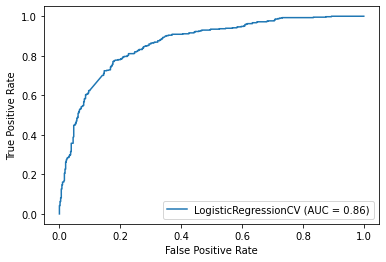

In [206]:
plot_roc_curve(lrc, x_test, y_test)

In [171]:
rfc.predict(create_feature_vector(post_tokenizer("Teacher Wonders If Outer Space Or Ocean Better Theme For Bulletin Board Listing Coronavirus Rules")).reshape(1,-1))

array([0])